In [1]:
# Import packages
import json
import pandas as pd  
import numpy as np
from tqdm.notebook import tqdm

In [2]:
# Read data
train = pd.read_json('data/train.json', lines=True) 
test = pd.read_json('data/test.json', lines=True) 
# Divide test data into the two subsets: Private Test and Public Test
# seq_length=107 in Public Test while seq_length=130 in Private Test
test_public = test[test["seq_length"] == 107]
test_private = test[test["seq_length"] == 130]

# Print the first sample for testing
df = pd.DataFrame(train)
df.iloc[0]

index                                                                  0
id                                                          id_001f94081
sequence               GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...
structure              .....((((((.......)))).)).((.....((..((((((......
predicted_loop_type    EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
signal_to_noise                                                    6.894
SN_filter                                                              1
seq_length                                                           107
seq_scored                                                            68
reactivity_error       [0.1359, 0.20700000000000002, 0.1633, 0.1452, ...
deg_error_Mg_pH10      [0.26130000000000003, 0.38420000000000004, 0.1...
deg_error_pH10         [0.2631, 0.28600000000000003, 0.0964, 0.1574, ...
deg_error_Mg_50C       [0.1501, 0.275, 0.0947, 0.18660000000000002, 0...
deg_error_50C          [0.2167, 0.34750000000000003

In [3]:
## get adjacent matrix from structure sequence

## here I calculate adjacent matrix of each base pair, 
## but eventually ignore difference of base pair and integrate into one matrix
Ss = []
for i in range(len(train)):
    seq_length = train["seq_length"].iloc[i]
    structure = train["structure"].iloc[i]
    sequence = train["sequence"].iloc[i]

    cue = []
    a_structures = {
        ("A", "U") : np.zeros([seq_length, seq_length]),
        ("C", "G") : np.zeros([seq_length, seq_length]),
        ("U", "G") : np.zeros([seq_length, seq_length]),
        ("U", "A") : np.zeros([seq_length, seq_length]),
        ("G", "C") : np.zeros([seq_length, seq_length]),
        ("G", "U") : np.zeros([seq_length, seq_length]),
    }
    a_structure = np.zeros([seq_length, seq_length])
    for i in range(seq_length):
        if structure[i] == "(":
            cue.append(i)
        elif structure[i] == ")":
            start = cue.pop()
#                 a_structure[start, i] = 1
#                 a_structure[i, start] = 1
            a_structures[(sequence[start], sequence[i])][start, i] = 1
            a_structures[(sequence[i], sequence[start])][i, start] = 1
    
    a_strc = np.stack([a for a in a_structures.values()], axis = 2)
    a_strc = np.sum(a_strc, axis = 2, keepdims = True)
    Ss.append(a_strc)

Ss = np.array(Ss)
print(Ss.shape)

(2400, 107, 107, 1)


In [4]:
# Check number of pairs (edges)
np.sum(Ss[0,:,:,0] == 1)

46

In [5]:
# Count number of "(", should be half of number of pairs
np.sum(Ss[0,:,:,0] == 1)
counter_left_pair = 0
for char in train["structure"].iloc[0]:
  if char == "(":
    counter_left_pair += 1
counter_left_pair

23

In [6]:
Ss[0,:,:,0]
struct_adj = Ss[0,:,:,0] # Reshape to (seq_length,seq_length)

In [7]:
def get_struct_adj(data = train, sequential_edges = False):
    # Get adjacency matrix from sample structure sequence
    # Include edges between base pairs
    # If sequential_edges == False, do not include edges between sequential bases
    # If sequential_edges == True, add these edges, which correspond to the diagonals -1 and 1 in the adjacency matrix (assuming undirected edges)
    struct_adj = []
    for ix in range(len(data)):
        seq_length = data["seq_length"].iloc[ix]
        structure = data["structure"].iloc[ix]
        sequence = data["sequence"].iloc[ix]

        queue = [] # Store indices corresponding to "(" in queue

        sample_struct_adj = np.zeros([seq_length, seq_length])
        for jx in range(seq_length):
            if structure[jx] == "(":
                queue.append(jx) # Append index of "(" in base pair to queue
            elif structure[jx] == ")":
                start = queue.pop() # Retrieve index of last "(" in queue, corresponding to ")" at jx
                sample_struct_adj[start, jx] = 1 # Add edge from "(" to ")"
                sample_struct_adj[jx, start] = 1 # Add edge from ")" to "(" (assume undirected)

        if sequential_edges == True:
            ones = np.ones(seq_length-1) # Match length of -1 and 1 diagonals in sample_struct_adj
            sample_struct_adj += np.diag(ones,1) # Add sequential edges (i,i+1) 
            sample_struct_adj += np.diag(ones,-1) # Add sequential edges (i+1,i) (assume non-directed)

        struct_adj.append(sample_struct_adj)

    struct_adj = np.array(struct_adj)
    return struct_adj 

In [8]:
mySs = get_struct_adj(data = train)
print(mySs.shape)
mySs = mySs[:,:,:,np.newaxis] # Reshape to match structure adjacency from reference
print(mySs.shape)

# Check that the implementation is equivalent to reference
np.array_equal(Ss,mySs)

(2400, 107, 107)
(2400, 107, 107, 1)


True

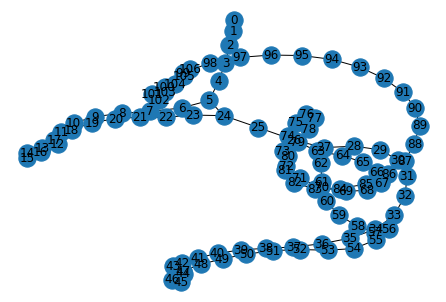

In [9]:
import networkx as nx 
  
A  =  get_struct_adj(data=train, sequential_edges=True) # Include sequential edges
A = A[0,:,:] # Take adjacency matrix of first sample

# ones = np.ones(seq_length-1)
# A += np.diag(ones,1) # add sequential edges (i,i+1) 
# A += np.diag(ones,-1) # add sequential edges (i+1,i) (assume non-directed)

G = nx.from_numpy_matrix(np.array(A))
nx.draw(G, with_labels=True)

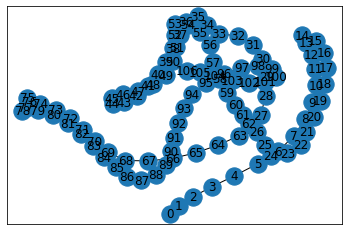

In [10]:
#  Try to make graph non-overlapping?
spring = nx.spring_layout(G)
nx.draw_networkx(G,spring)

In [11]:
a = np.load('data/bpps/id_001f94081.npy') 
print(a.shape)

(107, 107)


In [12]:
# Look at edges for one of the paired bases (row index 5)
struct_adj[5,:]
bpps_base5 = a[5,:]

In [13]:
np.where(struct_adj[5,:] == 1) # Find pair of base with index 5

(array([24], dtype=int64),)

In [14]:
np.argmax(bpps_base5) # Find maximum base pair probability for base with index 5

24

In [15]:
# Example snippet of creating distance matrix for training sample, where seq_length=107
idx = np.arange(train["seq_length"].iloc[0])
Ds = []
for i in range(len(idx)):
    d = np.abs(idx[i] - idx)
    Ds.append(d)
print(Ds[0]) # Before converting absolute index distance to distance measure
# Here Ds is a list of seq_length arrays, each with length seq_length

Ds = np.array(Ds) + 1
Ds = 1/Ds
Ds = Ds[None, :,:] # Expand the dimensions of the array to allow stacking matrices for all samples 
print(Ds.shape)
Ds = np.repeat(Ds, len(train), axis = 0) # Repeat the distance array for each sample (even though they are identical)
# Here, Ds is transformed to the distance measured and reshaped into adjacency matrices for each sample, with values being the distance measure between nodes
print(Ds.shape)

Dss = []
for i in [1, 2, 4]: 
    Dss.append(Ds ** i)
Ds = np.stack(Dss, axis = 3)
print(Ds.shape)
# Here, the power in the denominator of the distance measure expression is applied, resulting in 3 different distance adjacency matrices for each sample

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106]
(1, 107, 107)
(2400, 107, 107)
(2400, 107, 107, 3)


In [16]:
def get_node_features(data = train):
    # Create a node feature matrix for each sample in data
    # Encode feature vectors as one-hot arrays  
    # Included features: 
    #   Base (given by sequence)
    #   Loop type (given by predicted_loop_type)
    # Could also include sequence, i.e. "." "(" and ")", but I don't see how this provides any interesting information if the structure adjacency matrix is used
    X = [] # Stacked node feature matrices for all samples in data
    
    for ix in range(len(data)):
        seq_length = data["seq_length"].iloc[ix]
        sequence = train["sequence"].iloc[ix]
        predicted_loop_type = train["predicted_loop_type"].iloc[ix]

        X_sample = [] # Node feature matrix for current sample

        for jx in range(seq_length):
            # Base one hot
            bases = np.array(['A', 'G', 'U', 'C']) # Different order than reference notebook (A,G,C,U)
            x_base = np.zeros(len(bases))
            x_base[bases == sequence[jx]] = 1 # Set base one-hot to 1 at correct index

            # Predicted Loop Type one hot
            loop_types = np.array(['S', 'M', 'I', 'B', 'H', 'E', 'X'])
            x_loop = np.zeros(len(loop_types))
            x_loop[loop_types == predicted_loop_type[jx]] = 1 # Set loop-type one-hot to 1 at correct index

            x = np.concatenate((x_base,x_loop)) # Concatenate to one node feature vector
            X_sample.append(x) # Append node feature vector to node feature matrix
        X_sample = np.array(X_sample)
        X.append(X_sample) # Append node feature matrix for current graph
    X = np.array(X)
    return X
X_tr = get_node_features(train)

In [17]:
print(X_tr.shape)
# Print feature vector of node 42 in sample 0 to see that the function assigns one hot correctly
print(X_tr[0,42])
print(train["sequence"].iloc[0][42])
print(train["predicted_loop_type"].iloc[0][42])
# First 4 are sequence one hot, last 7 are loop type one hot

(2400, 107, 11)
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
G
S


In [18]:
## sequence
def return_ohe(n, i):
    tmp = [0] * n
    tmp[i] = 1
    return tmp

def get_input(train):
    ## get node features, which is one hot encoded
    mapping = {}
    vocab = ["A", "G", "C", "U"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_node = np.stack(train["sequence"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))

    mapping = {}
    vocab = ["S", "M", "I", "B", "H", "E", "X"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_loop = np.stack(train["predicted_loop_type"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    mapping = {}
    vocab = [".", "(", ")"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_structure = np.stack(train["structure"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    
    X_node = np.concatenate([X_node, X_loop], axis = 2)
    
    ## interaction
    a = np.sum(X_node * (2 ** np.arange(X_node.shape[2])[None, None, :]), axis = 2)
    vocab = sorted(set(a.flatten()))
    print(vocab)
    ohes = []
    for v in vocab:
        ohes.append(a == v)
    ohes = np.stack(ohes, axis = 2)
    X_node = np.concatenate([X_node, ohes], axis = 2).astype(np.float32)
    
    
    print(X_node.shape)
    return X_node

X_node = get_input(train)

[17, 18, 20, 24, 33, 34, 36, 40, 65, 66, 68, 72, 129, 130, 132, 136, 257, 258, 260, 264, 513, 514, 516, 520, 1025, 1026, 1028, 1032]
(2400, 107, 39)


In [19]:
print(X_tr[0,42])
print(X_node[0,42])

[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


TARGET ARRAYS

In [49]:
from torch.utils.data import DataLoader 
import torch
target_labels = ["reactivity", "deg_Mg_pH10", "deg_Mg_50C", "deg_pH10", "deg_50C"]

train_ae = train[train.signal_to_noise > 4].reset_index(drop = True) # remove noisy data
y_train_ae = []
seq_length = train_ae["seq_length"].iloc[0] # Get number of nodes (lenght of sequence)
#seq_scored = train_ae["seq_scored"].iloc[0] # Get number of nodes with ground truth targets
for target in target_labels:
    y_ae = np.vstack(train_ae[target]) # Create (n_samples, seq_scored) arrays for each target
    y_train_ae.append(y_ae) # Append array for each target
y_train_ae = np.stack(y_train_ae, axis=2) # Join the target arrays along last axis to match shape of feature arrays
y_train_ae = y_train_ae.reshape(y_train_ae.shape[0],-1).astype(float)
print(y_train_ae.shape)

y_train_loader = DataLoader(y_train_ae, batch_size=16, shuffle=True)
print(len(y_train_loader))

(1350, 340)
85


In [68]:
# Define MCRMSE loss function, taking one sample at a time 
# Inputs should have dimensions (n_nodes, n_targets)
def MCRMSE_single(y_true, y_pred, only_scored=False):
    # Extract the scored targets
    seq_scored = train["seq_scored"].iloc[0] # Get number of nodes with ground truth targets
    y_pred = y_pred[:seq_scored, :] 
    # true = y_true[:seq_scored, :] # Not necessary since only scored targets are included, could include dummy values instead as in reference notebook

    y_diff = y_pred - y_true
    mse = torch.mean(y_diff**2, axis=0) # Average over nodes in each sample for every target
    rmse = torch.sqrt(mse)
    
    num_scored = 5 # Include all targets by default
    if only_scored == True:
        num_scored = 3 # Include only scored targets if specified by keyword (assumes correct ordering of targets in y_true and y_pred)

    mcrmse = torch.mean(rmse[:num_scored]) # Average over included targets

    return mcrmse

In [33]:
def MCRMSE(y_true, y_pred, only_scored=False):
    # Extract the scored targets
    seq_scored = train["seq_scored"].iloc[0] # Get number of nodes with ground truth targets
    y_pred = y_pred[:, :seq_scored, :] 
    # true = y_true[:, :seq_scored, :] # Not necessary since only scored targets are included, could include dummy values instead as in reference notebook

    y_diff = y_pred - y_true
    mse = torch.mean(y_diff**2, axis=1) # Average over nodes in each sample for every target
    rmse = torch.sqrt(mse)
    
    num_scored = 5 # Include all targets by default
    if only_scored == True:
        num_scored = 3 # Include only scored targets if specified by keyword (assumes correct ordering of targets in y_true and y_pred)

    mcrmse = torch.mean(rmse[:, :num_scored], axis=1) # Average over included targets

    return mcrmse

In [118]:
import torch
from torch.nn import Linear
from torch.nn import ReLU
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import random

class AE(nn.Module):
  def __init__(self, **kwargs):
    super(AE,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(kwargs["input_shape"],512),
                  nn.ReLU(True),
                  nn.Linear(512,512),
                  #nn.ReLU(True),
                  #nn.Linear(512,512),
                  #nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  #nn.Linear(512,512),
                  #nn.ReLU(True),
                  nn.Linear(512,512),
                  nn.ReLU(True),
                  nn.Linear(512,kwargs["input_shape"]),
                  )
    
 
  def forward(self,x):
    r = random.random()/2
    x = F.dropout(x, p=r, training=True)
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x 

In [119]:
#Train AE_model

autoencoder = AE(input_shape=340)
mse = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(autoencoder.parameters(), lr=0.001, momentum=0.9)
EPOCHS = 50

for epoch in range(EPOCHS): 

    running_loss = 0.0
    for i, data in enumerate(y_train_loader):
        # get the inputs; data is a list of [inputs, labels]

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = autoencoder(data.float())
        loss = mse(data.float(), outputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print('[%d, %10d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')


[1,          1] loss: 0.00430
[2,          1] loss: 0.00432
[3,          1] loss: 0.00395
[4,          1] loss: 0.00387
[5,          1] loss: 0.00345
[6,          1] loss: 0.00297
[7,          1] loss: 0.00198
[8,          1] loss: 0.00161
[9,          1] loss: 0.00171
[10,          1] loss: 0.00128
[11,          1] loss: 0.00149
[12,          1] loss: 0.00150
[13,          1] loss: 0.00132
[14,          1] loss: 0.00170
[15,          1] loss: 0.00149
[16,          1] loss: 0.00166
[17,          1] loss: 0.00144
[18,          1] loss: 0.00168
[19,          1] loss: 0.00177
[20,          1] loss: 0.00151
[21,          1] loss: 0.00161
[22,          1] loss: 0.00135
[23,          1] loss: 0.00188
[24,          1] loss: 0.00177
[25,          1] loss: 0.00148
[26,          1] loss: 0.00157
[27,          1] loss: 0.00153
[28,          1] loss: 0.00152
[29,          1] loss: 0.00174
[30,          1] loss: 0.00179
[31,          1] loss: 0.00181
[32,          1] loss: 0.00170
[33,          1] 

In [100]:
autoencoder.eval()
print(y_train.shape)
for i in range(y_train.shape[0]):
    y_train_tensor = torch.Tensor(y_train[i,:,:].astype(float).flatten())
    
    outputs = autoencoder(y_train_tensor)   
    outputs = outputs.reshape(68,5)
    y_train[i,:,:] = outputs.detach().numpy() 
print(y_train.shape)

(2400, 68, 5)
(2400, 68, 5)


In [82]:
X = get_node_features(train)
print(X.shape)
A_pairs = get_struct_adj(data = train)
print(A_pairs.shape)

(2400, 107, 11)
(2400, 107, 107)


In [83]:
import torch
from torch.nn import Linear
from torch.nn import ReLU
import torch.nn.functional as F

In [84]:
class myGraphConv(torch.nn.Module):
    """
    The graph neural network operator from the “Weisfeiler and Leman Go 
    Neural: Higher-order Graph Neural Networks” paper

    x' = x_i W_1.T + (Adj x_i) W_2.T

    Arguments:
        in_channels (int): Number of features (size) of each input node
        out_channels (int): Number of features (size) of each output node
    
    forward performs the graph neural network operation
    Arguments:
        x (torch tensor): The input node features of shape (n_nodes, in_channels) 
        Adj (torch tensor): The adjacency matrix of the graph of shape (n_nodes, n_nodes) 
    Returns: 
        x' (torch tensor): Output node feature matrix of shape (n_nodes, out_channels)
    """
    # Notes:
    ## Possibly change to allow x of shape (n_samples, n_nodes, in_channels) 
    ## and Adj of shape (n_samples, n_nodes, n_nodes).
    ## Also should add boolean argument bias for the linear weights.
    ## GraphConv seems to only use bias for W_2 if I understand the source code correctly
    ## (see lin_r = ... bias=False).a


    def __init__(self, in_channels, out_channels):
        super(myGraphConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.lin_1 = Linear(in_channels, out_channels, bias=True) # bias=False to match GraphConv? Check source code
        self.lin_2 = Linear(in_channels, out_channels, bias=True)  

        self.reset_parameters()
   
    def reset_parameters(self):
        self.lin_1.reset_parameters()
        self.lin_2.reset_parameters()

    def forward(self, x, Adj):
        # Shapes of arguments, weight matrices and output
        # x: (n_nodes, in_channels)
        # Adj: (n_nodes, n_nodes)
        # W_1: (in_channels, out_channels)
        # W_2: (in_channels, out_channels)
        # out: (n_nodes, out_channels)
        out = torch.matmul(Adj,x) # Calculate contributions from adjacent nodes, this is equivalent to summing over edge weights assuming Adj contains the edge weights
        out = self.lin_2(out) # Multiply with weight matrix for adjacent nodes
        out += self.lin_1(x) # Add contribution from self
        return out

    # The method that returns a printable representation of the operator, copy to match GraphConv source code 
    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


In [85]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345) # For reproducible results
        self.conv = myGraphConv(X.shape[2], hidden_channels) # This uses my implementation of GraphConv. Change to torch-geometric version when possible
        self.lin = Linear(hidden_channels, 5) # Map to the 5 output targets with dense layer
        self.relu = ReLU()

    def forward(self, x, Adj):
        # 1. Obtain node embeddings, use GraphConv layers with ReLU for non-linearity
        x = self.conv(x, Adj) # Give adjacency matrix instead of edge_index and edge_weight
        x = self.relu(x)

        # 2. Readout layer
        # No pooling is required, we want target labels for each node, not for the entire graph

        # 3. Apply a final classifier 
        # Use a single layer as classifier to map to the targets
        x = self.lin(x)

        # No LogSoftmax needed, possibly some other function to map to correct targets?

        return x
    

In [86]:
# Define MCRMSE loss function
# Include all 5 targets by default, allow optional argument to calculate MCRMSE of scored targets only.
# Assumes targets are ordered such that the first 3 targets are the scored ones.
# Inputs should have dimensions (n_samples, n_nodes, n_targets)
def MCRMSE(y_true, y_pred, only_scored=False):
    # Extract the scored targets
    seq_scored = train["seq_scored"].iloc[0] # Get number of nodes with ground truth targets
    y_pred = y_pred[:, :seq_scored, :] 
    # true = y_true[:, :seq_scored, :] # Not necessary since only scored targets are included, could include dummy values instead as in reference notebook

    y_diff = y_pred - y_true
    mse = torch.mean(y_diff**2, axis=1) # Average over nodes in each sample for every target
    rmse = torch.sqrt(mse)
    
    num_scored = 5 # Include all targets by default
    if only_scored == True:
        num_scored = 3 # Include only scored targets if specified by keyword (assumes correct ordering of targets in y_true and y_pred)

    mcrmse = torch.mean(rmse[:, :num_scored], axis=1) # Average over included targets

    return mcrmse

In [87]:
"""
# Define MCRMSE loss function, taking one sample at a time 
# Inputs should have dimensions (n_nodes, n_targets)
def MCRMSE_single(y_true, y_pred, only_scored=False):
    # Extract the scored targets
    seq_scored = train["seq_scored"].iloc[0] # Get number of nodes with ground truth targets
    y_pred = y_pred[:seq_scored, :] 
    # true = y_true[:seq_scored, :] # Not necessary since only scored targets are included, could include dummy values instead as in reference notebook

    y_diff = y_pred - y_true
    mse = torch.mean(y_diff**2, axis=0) # Average over nodes in each sample for every target
    rmse = torch.sqrt(mse)
    
    num_scored = 5 # Include all targets by default
    if only_scored == True:
        num_scored = 3 # Include only scored targets if specified by keyword (assumes correct ordering of targets in y_true and y_pred)

    mcrmse = torch.mean(rmse[:num_scored]) # Average over included targets

    return mcrmse
"""

'\n# Define MCRMSE loss function, taking one sample at a time \n# Inputs should have dimensions (n_nodes, n_targets)\ndef MCRMSE_single(y_true, y_pred, only_scored=False):\n    # Extract the scored targets\n    seq_scored = train["seq_scored"].iloc[0] # Get number of nodes with ground truth targets\n    y_pred = y_pred[:seq_scored, :] \n    # true = y_true[:seq_scored, :] # Not necessary since only scored targets are included, could include dummy values instead as in reference notebook\n\n    y_diff = y_pred - y_true\n    mse = torch.mean(y_diff**2, axis=0) # Average over nodes in each sample for every target\n    rmse = torch.sqrt(mse)\n    \n    num_scored = 5 # Include all targets by default\n    if only_scored == True:\n        num_scored = 3 # Include only scored targets if specified by keyword (assumes correct ordering of targets in y_true and y_pred)\n\n    mcrmse = torch.mean(rmse[:num_scored]) # Average over included targets\n\n    return mcrmse\n'

In [101]:
# Instantiate GNN model, optimizer and loss function
model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adjust learning rate
criterion = MCRMSE_single # Mean column-wise root mean square error (MCRMSE) loss

# Define trainer function for GNN
def run_training(X_data, Adj_data):
    model.train()
    running_loss = 0 # For printing training loss
    for ix in range(len(X_data)):  # Iterate over samples in the training dataset
        out = model(X_data[ix,:,:], Adj_data[ix,:,:]) # Perform a single forward pass.
    # out = model(X_data, Adj_data) # all in one pass, no for loop
        loss = criterion(torch.tensor(y_train[ix,:,:].astype(float)), out)  # Compute the loss. Convert target vector to float (apparently important for back-propagation)
        loss.backward()  # Derive gradients
        optimizer.step()  # Update parameters based on gradients
        optimizer.zero_grad()  # Clear gradients

        # Print statistics
        running_loss += loss.item()
        if ix % 200 == 199:    # Print average loss every 200 mini-batches (every 200 samples in this case)
            print('[sample %5d] loss: %.3f' %
                    (ix + 1, running_loss / 200))
            running_loss = 0.0 # Reset running loss
# Convert training data inputs to pytorch tensors and run training
X_torch = torch.tensor(X.astype(np.float32))
Adj_torch = torch.tensor(A_pairs.astype(np.float32))
run_training(X_torch, Adj_torch)


GNN(
  (conv): myGraphConv(11, 64)
  (lin): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
)
[sample   200] loss: 0.273
[sample   400] loss: 0.261
[sample   600] loss: 0.258
[sample   800] loss: 0.258
[sample  1000] loss: 0.237
[sample  1200] loss: 0.254
[sample  1400] loss: 0.260
[sample  1600] loss: 0.262
[sample  1800] loss: 0.239
[sample  2000] loss: 0.238
[sample  2200] loss: 0.253
[sample  2400] loss: 0.260


In [89]:
X_test_public = get_node_features(data = test_public)
print(X_test_public.shape)
A_test_public = get_struct_adj(data = test_public)
print(A_test_public.shape)

(629, 107, 11)
(629, 107, 107)


In [90]:
# Define prediction function
def run_prediction(X_data, Adj_data):
    model.eval()
    y_pred = []
    for ix in range(len(X_data)): 
        out = model(X_data[ix,:,:], Adj_data[ix,:,:]) # Perform a single forward pass.
        y_pred.append(out.detach().numpy())
    y_pred = np.array(y_pred)
    return y_pred
# Convert test data inputs to pytorch tensors and run prediction
X_test_public_torch = torch.tensor(X_test_public.astype(np.float32))
A_test_public_torch = torch.tensor(A_test_public.astype(np.float32))
y_pred = run_prediction(X_test_public_torch, A_test_public_torch)


In [91]:
print(y_pred.shape)

(629, 107, 5)


In [92]:
# Run prediction on training data as a test run
y_train_pred = run_prediction(X_torch, Adj_torch)

In [106]:
target_labels = ["reactivity", "deg_Mg_pH10", "deg_Mg_50C", "deg_pH10", "deg_50C"]

y_train = []
seq_length = train["seq_length"].iloc[0] # Get number of nodes (lenght of sequence)
seq_scored = train["seq_scored"].iloc[0] # Get number of nodes with ground truth targets
for target in target_labels:
    y = np.vstack(train[target]) # Create (n_samples, seq_scored) arrays for each target
    y_train.append(y) # Append array for each target
y_train = np.stack(y_train, axis=2) # Join the target arrays along last axis to match shape of feature arrays
print(y_train.shape)


(2400, 68, 5)


In [107]:
# Calculate score on training data
y_train_torch = torch.tensor(y_train.astype(float))
y_train_pred_torch = torch.tensor(y_train_pred.astype(float))
training_score = MCRMSE(y_train_torch, y_train_pred_torch, only_scored=False)
training_score_only_scored = MCRMSE(y_train_torch, y_train_pred_torch, only_scored=True)

In [96]:
print(f"Mean score on training data, all 5 targets: {float(torch.mean(training_score)):.5}")
print(f"Mean score on training data, only scored targets: {float(torch.mean(training_score_only_scored)):.5}")

Mean score on training data, all 5 targets: 0.60481
Mean score on training data, only scored targets: 0.56616
